In [6]:
import yfinance as yf
import bs4 as bs
import requests
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sn
import pandas_datareader.data as web
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot

plt.style.use('fivethirtyeight')

In [7]:
def get_bova_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_companies_listed_on_B3')
    soup = bs.BeautifulSoup(resp.text)
    table = soup.find('table')
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[1].text
        tickers.append(ticker)
        
    return tickers

In [8]:
tickers = get_bova_tickers()

In [9]:
tickers[:6]

['ABEV3', 'AZUL4', 'BTOW3', 'B3SA3', 'BBAS3', 'BBSE3']

In [10]:
start = dt.datetime(2015,7,30)
end = dt.datetime(2020,7,30)

df = pd.DataFrame()

for ticker in tickers:
    tick = yf.Ticker(ticker)
    df1 = web.DataReader(ticker+'.SA', 'yahoo', start, end)
    df[ticker + ' - Adj Close'] = df1['Adj Close']

In [11]:
df_returns = pd.DataFrame()
for col in df.columns:
    stock = col.split('-')[0]
    df_returns[stock + 'Return'] = df[col].pct_change(1) * 100

In [12]:
# getting log returns
log_return = np.log(df/df.shift(1))

In [14]:
print('Returns shape ' + str(df_returns.shape))
print('Close Prices shape ' + str(df.shape))
print('Log Returns shape ' + str(log_return.shape))

Returns shape (1243, 73)
Close Prices shape (1243, 73)
Log Returns shape (1243, 73)


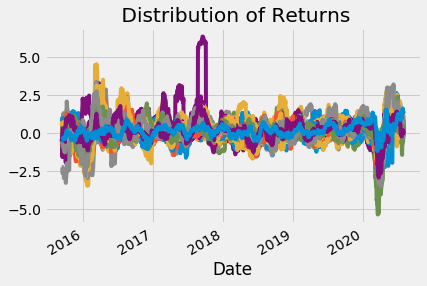

In [15]:
# checking if stationary
# not stationary BBAS3, CPFE3
# stationary RAIL3, WEGE3, BBDC4,COGN3
for ticker in tickers:
    df_returns[ticker + ' Return'].rolling(30).mean().plot()
    pyplot.title(' Distribution of Returns')

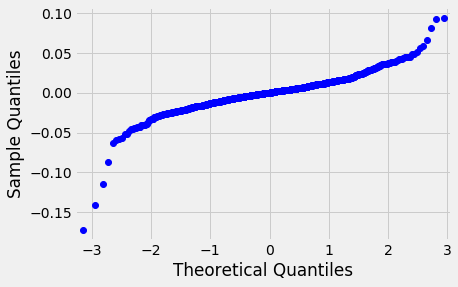

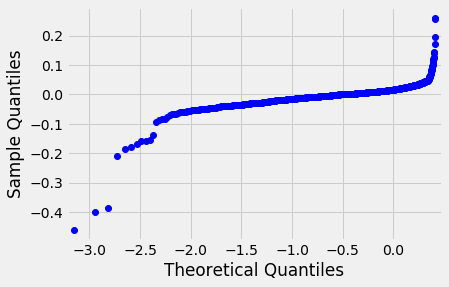

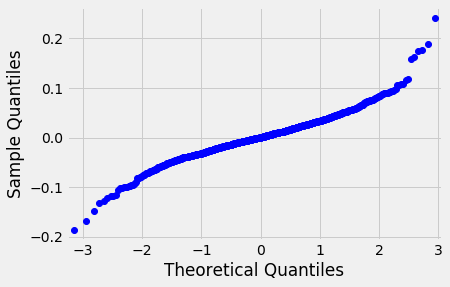

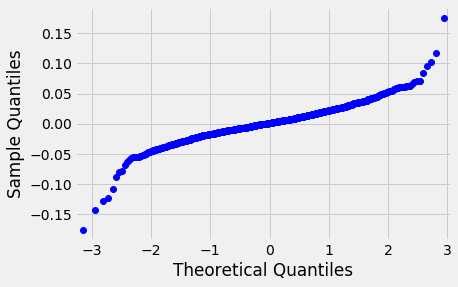

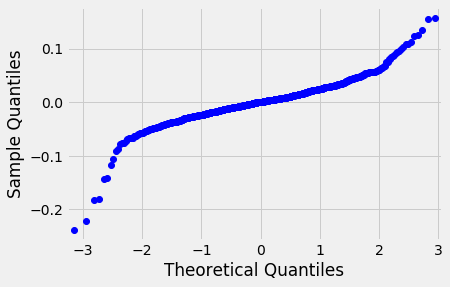

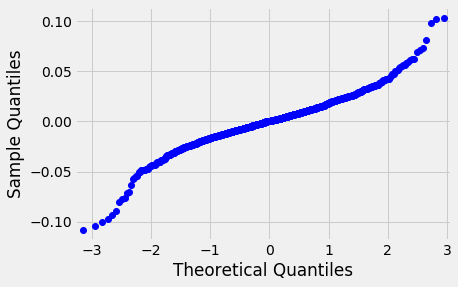

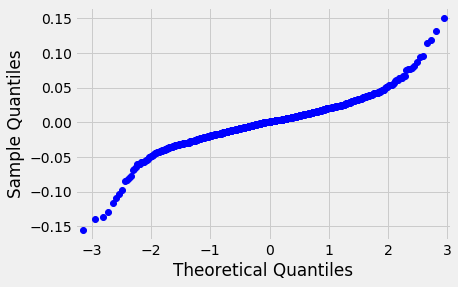

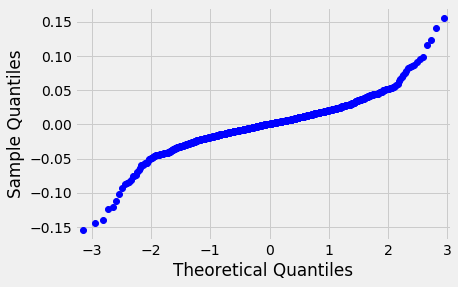

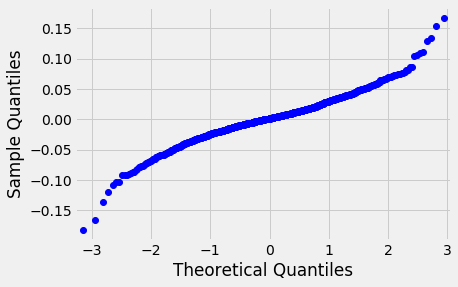

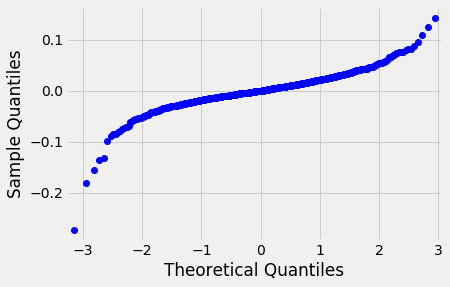

In [16]:
# checks if results are log-normally distributed as assumed in theory
for ticker in tickers[:10]:
    qqplot(log_return[ticker + ' - Adj Close'], line='s')

In [17]:
# checking if returns are auto-correlated
# SUZB comecou final 2017, IRBR3 tbm.
# Gol, USIM5, PCAR4 sao os que mais tem autocorrelacao
auto_corr_stocks = []
for ticker in tickers:
    auto = log_return[ticker + ' - Adj Close'].autocorr()
    auto_corr_stocks.append([auto])

In [18]:
auto_corr_stocks = pd.Series(auto_corr_stocks)
auto_corr_stocks.sort_values()

67     [-0.2045149386654352]
53    [-0.19546983816337427]
25     [-0.1721907156929085]
42    [-0.14804783845494007]
46     [-0.1459062727422082]
               ...          
32    [0.053734467686560074]
33     [0.06229412635488226]
68     [0.06369780134650746]
62     [0.08397603339170641]
39     [0.09696451175586321]
Length: 73, dtype: object

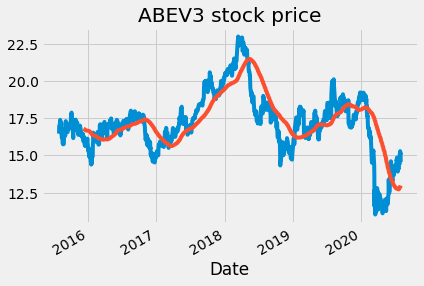

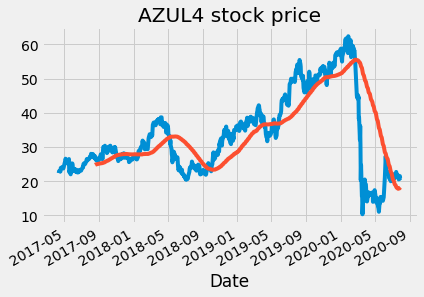

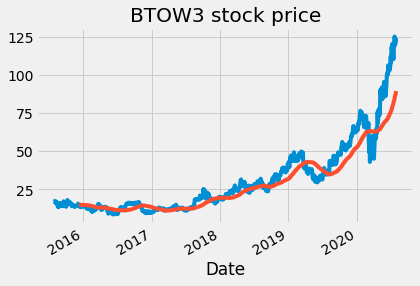

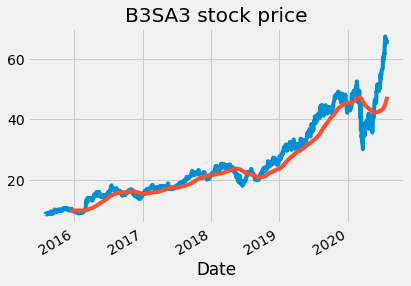

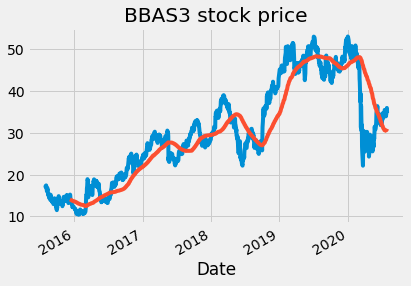

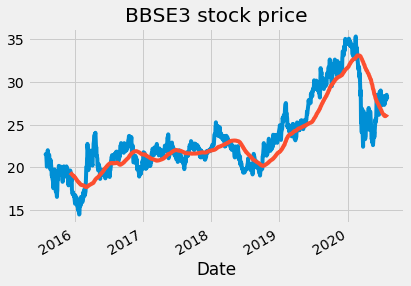

In [19]:
# checking for seasonality
for ticker in tickers[:6]:
    df[ticker + ' - Adj Close'].plot()
    df[ticker + ' - Adj Close'].rolling(90).mean().plot()
    pyplot.title(ticker + ' stock price')
#     df[ticker + ' - Adj Close'].rolling(30).std().plot()
    pyplot.show()

In [20]:
# y year volatility of each stock
vols = []
for stock in df_returns.columns:
    vols.append(df_returns[stock].std())

In [21]:
# getting covariance matrix
cov_matrix = np.cov(df_returns, bias=True)

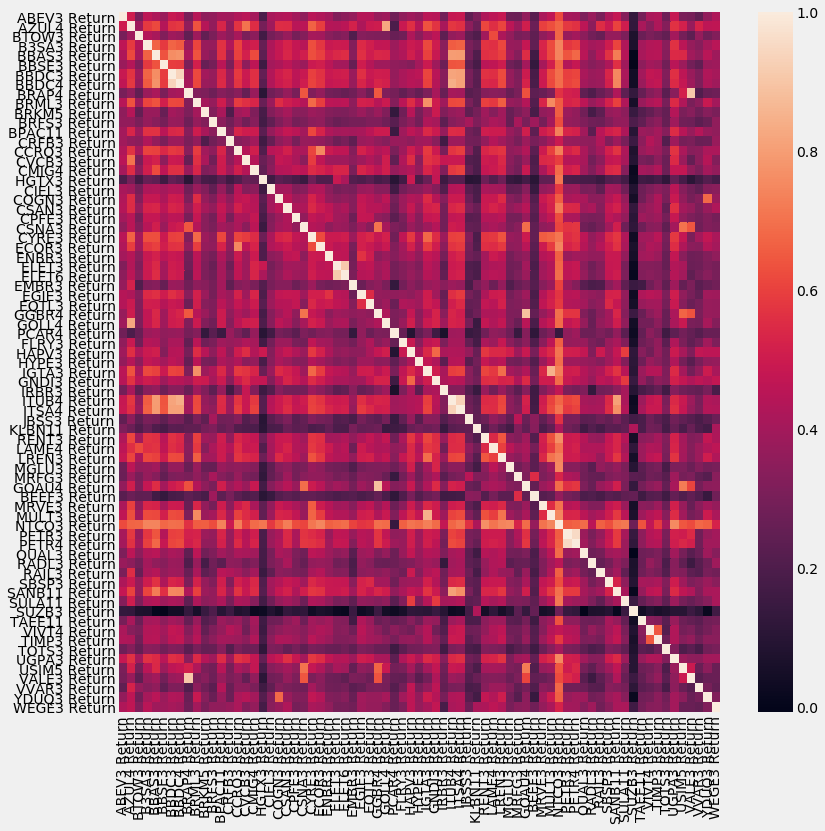

In [22]:
# heatmap of covariances
df_corr = df_returns.corr()
fig, ax = plt.subplots(figsize=(12,12))
sn.heatmap(df_corr,
            xticklabels=df_corr.columns,
            yticklabels=df_corr.columns)

In [23]:
# From here onwards, most is from the internet. There were just some 
# adjustements to fit our specifc case.

weights = np.array(np.random.random(73))
print('Random Weights:')
print(weights)

print('Rebalance')
weights = weights/np.sum(weights)
print(weights)

# expected return
print('Expected Portfolio Return')
exp_ret = np.sum((log_return.mean()*weights)*1243)
print(exp_ret)

# expected volatility
print('Expected Volatility')
exp_vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*1243, weights)))
print(exp_vol)

# Sharpe Ratio
print('Sharpe Ratio')
SR = exp_ret/exp_vol
print(SR)

Random Weights:
[0.45105739 0.52668022 0.45162065 0.20285369 0.49261845 0.71367782
 0.11858634 0.86316465 0.60818994 0.80838853 0.73583298 0.86202512
 0.84806504 0.90986452 0.6226617  0.7240804  0.43185738 0.62362111
 0.36835059 0.15736634 0.87481372 0.46509323 0.71495469 0.73719058
 0.0074361  0.19905395 0.22731688 0.9027983  0.30419271 0.37235612
 0.90251388 0.19133954 0.25832626 0.4627238  0.26861475 0.0139548
 0.34511709 0.98938224 0.4815254  0.2133284  0.17276475 0.01102038
 0.78605173 0.89536721 0.24250069 0.93718742 0.77469739 0.51545025
 0.23166441 0.98454475 0.19735064 0.76678939 0.632759   0.65788208
 0.21032277 0.72031886 0.94833284 0.24990765 0.91639808 0.05397085
 0.52023101 0.89060878 0.672093   0.95185011 0.67217188 0.3992235
 0.66289875 0.42954169 0.83381162 0.21394429 0.62538821 0.8418124
 0.3206218 ]
Rebalance
[0.01145046 0.01337021 0.01146476 0.00514961 0.01250552 0.0181173
 0.00301041 0.02191214 0.0154394  0.0205216  0.01867972 0.02188321
 0.02152882 0.02309766 0.01

In [24]:
num_ports = 5000
all_weights = np.zeros((num_ports, len(df.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports): 
    # weights 
    weights = np.array(np.random.random(73)) 
    weights = weights/np.sum(weights)  
	
    # save the weights
    all_weights[ind,:] = weights
	
    # expected return 
    ret_arr[ind] = np.sum((log_return.mean()*weights)*1243)

    # expected volatility 
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*1243, weights)))

    # Sharpe Ratio 
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

Text(0, 0.5, 'Return')

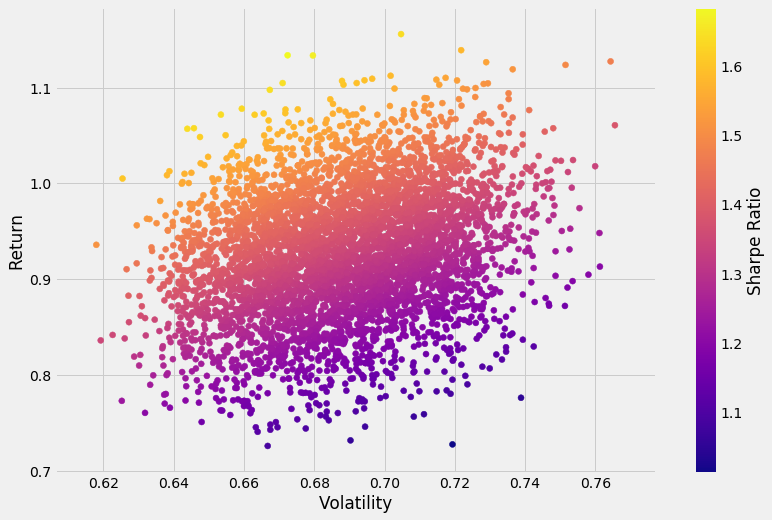

In [25]:
# plot the data
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

In [26]:
sharpe_arr.max()

1.685975383308766

In [27]:
# Portfolio with highest sharpe ratio
print('Portfolio with highest sharpe ratio has a return of ' + str(round(ret_arr[1095],3)) + '%')
print('Portfolio with highest sharpe ratio has a volatility of ' + str(round(vol_arr[1095],3)))

Portfolio with highest sharpe ratio has a return of 0.877%
Portfolio with highest sharpe ratio has a volatility of 0.676


In [28]:
def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 1243
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*1243,weights)))
    sr = ret/vol 
    return np.array([ret,vol,sr])

In [29]:
get_ret_vol_sr(np.random.random(73))

array([39.36876389, 29.11687557,  1.35209438])

In [30]:
from scipy.optimize import minimize

In [31]:
# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)[2] * -1

In [32]:
# check allocation sums to 1
def check_sum(weights): 
	return np.sum(weights) - 1

In [33]:
cons = ({'type':'eq','fun':check_sum})

# create weight boundaries
bounds = ((0,0.1),)*73

In [34]:
# initial guess
random_guess = np.random.random(73)
init_guess = random_guess/np.sum(random_guess)

In [35]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [36]:
# possible sharpe ratio if we had a optimized the portfolio
-opt_results.fun

3.536416349871526